# Baum - Welch Reparameterization

A popular classic method in the HMM literature for inferring model parameters is the *Expectation-Maximization* algorithm. The primary tools needed for this mode of estimation is simply the forward and backward probabilities ($P(x_t|Y^{[0, t]})$ and $P(x_t|Y^{[t, T]})$, respectively) that we have already built up the necessary logic to estimate. In the context of HMMs, the expectation-maximization algorithm is referred to as the *Baum-Welch* optimization algorithm.

In general an expectation-maximization algorithm is an iterative method for performing maximum likelihood estimation when some of the data are missing. This method exploits the fact that the *Complete-Data Log-Likelihood* (CDLL) may be straightforward to maximize, even if the likelihood of the observed data is not.  Here, the CDLL is simply the true log-likelihood function of parameters $\theta$ based on both the observed and missing data.

Informally, the algorithm can be described as follows: start witih an initial guess for the paramerer vector $\theta_i$ and then iterate the following two steps until the desired convergence is reached:

- ***Expectation***: Compute conditional expectation values of the missing data given the observed data and the current estimate of parameters ($\theta$). Or, precisely, compute the conditional expectations of those functions of missing data that appear in the CDLL
- ***Maximization***: Maximize (with respect to $\theta$) the CDLL with the functions of the missing data replaced with their conditional expectations.

By iterating this process, the parameter vector will converge towards a local maximum of the likelihood function

known as the *Baum-Welch* algorithm, and is a particular instance of an Expectation-Maximization algorithm. While this algorithm still seeks to find the maximum likelihood solution to the problems introduced earlier, the procedure is slightly different, and can better solve for a unique minimum, while scaling better at times with dimensions.

Specifically, the BW algorithm (like all EM algorithms) takes place over two steps, which are iterated over until a convergence criteria has been reached. Those steps are:
- **Expectation**: calculate the most probable set of hidden states given a set of parameters
- **Maximization**: Assuming the hidden state sequence in the previous step is correct, what is the maximum likelihood set of transition parameters

Unlike the previous naive likelihood maximization, this algorithm works by first calculating the maximum likelihood (Bayesian) estimate of the hidden state given the observed sequence of states (assuming fixed transition $A$ and observation $B$ matrices):

$$ \gamma_i^t \equiv P(x_t = i| Y^T)$$

where $\gamma_i^t$ represents the probability of the hidden state being in state $i$ at time $t$, given the entire history of observations $Y^T$ (from $t=0 \to N$).

This represents the *expectation* step. Next, we update the parameters of the $A$ and $B$ matrix in the following way:

First, we calculate the transition probability of hidden state transitions, given all observations:

$$ \xi_t^{ji} \equiv P(x_t = i, x_{t+1} = j | Y^T ) = P(x_t = i | Y^{[0, t]})P(x_t = i, x_{t+1} = j)P(x_{t+1} = j | Y^{[t+1, T]} )P(y_{t+1} = j | x_{t=1} = j) $$

From this equation, we already know a few terms: $P(x_t = i| Y^{[0, t]})$ is simply the forward probability at tiem step $t$, similarly $P(x_{t+1} = j | Y^{[t+1, T]})$ is the backward probability at time $t+1$, the last term $P(y_{t+1} = j| X_{t+1} = j)$ is just the matrix element $B_{jj}$ of the observation matrix. Therefore, to determine $\xi_t^{ij}$, we just need to determine the middle term $P(x_t = i, x_{t+1} = j)$. However, this middle term is just the matrix element $A_{ij}$: the probability of a transition from $x_i \to x_j$. Therefore, we have the entire expression built from terms already at our disposal.

Once we have this $\xi_t^{ji}$ term, we update the transition matrix elements as

$$ A_{ij}^* = \frac{\sum_{t=1}^T \xi_t^{ij} }{\sum_{t=1}^T \gamma_i^t } $$

which is simply the expecten number of transitions $i\to j$ divided by the number of times that the system was in state $i$.
This provides the logic for updating the transition matrix terms, the remaining piece is to update the observation matrix terms.  Here, we set

$$ B_{ij}^* =  \frac{\sum_{t=1}^T \mathcal{I}[y_t = i]\gamma_j^t}{\sum_{t=1}^T \gamma_j^t}$$

Which can alternatively be written as

$$ B_{ij}^* = \frac{\sum_{t | y_t = i} \gamma_i^t}{\sum_{t=1}^T \gamma_i^t} $$ 

Which, intuitively, serves as a measure of the relative probability of being in state $i$ when the obervation is $i$.

For each of these expressions there are $N\times N$ terms to evaluate.



In [1]:
# First, import the necessary modules
import os
from copy import deepcopy
import numpy as np
from typing import Iterable, Optional, Tuple, Callable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="hls")

from hidden import dynamics
from hidden import infer

# here we assume the dynamics are symmetric
a = 0.1
b = 0.2

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [2]:
# And run a sample trajectory from this model of 1000 steps
hmm.initialize_dynamics(A, B)
hmm.run_dynamics(1000)
obs_ts = hmm.get_obs_ts()
state_ts = hmm.get_state_ts()

In [3]:
bayes_infer = infer.MarkovInfer(2, 2)

# First, we can check the forward and backward algorithms to be sure that there are no off-by-one errors
bayes_infer.forward_algo(obs_ts, A, B)
bayes_infer.backward_algo(obs_ts, A, B)

# Prediction of the forward and backward algorithms at each point in time
fwd_pred = [np.argmax(i) for i in bayes_infer.forward_tracker]
bak_pred = [np.argmax(i) for i in bayes_infer.backward_tracker]

# Probabilities of the system being in state 1
fwd_prob_one = [i[1] for i in bayes_infer.forward_tracker]
bak_prob_one = [i[1] for i in bayes_infer.backward_tracker]

# Smoothing operation
bayes_infer.bayesian_smooth(A)
smooth_prob_one = [i[1] for i in bayes_infer.bayes_smoother]


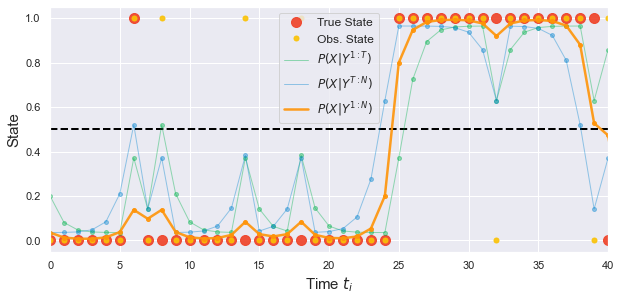

In [4]:

fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))

ax.axhline(0.5, linestyle='--', linewidth=2.0, color='k')

ax.plot(state_ts, 'o', markersize=10, color=sns.xkcd_rgb["tomato"], alpha=0.9, label="True State")
ax.plot(obs_ts, 'o', markersize=5, color=sns.xkcd_rgb["goldenrod"], alpha=0.9, label="Obs. State")

ax.plot(fwd_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["shamrock"], alpha=0.4)
ax.plot(bak_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["cerulean"], alpha=0.4)
ax.plot(smooth_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["tangerine"], alpha=0.9)

ax.plot(fwd_prob_one, linewidth=1.0, color=sns.xkcd_rgb["shamrock"], alpha=0.4, label=r"$P(X|Y^{1:T})$")
ax.plot(bak_prob_one, linewidth=1.0, color=sns.xkcd_rgb["cerulean"], alpha=0.4, label=r"$P(X|Y^{T:N})$")
ax.plot(smooth_prob_one, linewidth=2.5, color=sns.xkcd_rgb["tangerine"], alpha=0.9, label=r"$P(X|Y^{1:N})$")

ax.set_xlim([0,40])
ax.set_xlabel(r"Time $t_i$", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, ncol=1, frameon=True)


In [5]:
# Here, we can see that the smoother estimate gets most inferrences right (at
# least for this window slice), while both the forward, and backward algorithms
# get some wrong. The smoother gets fooled by the quick state switch around t=15
# but not on either end of the more prolonged state switch around t=20 - 26

pred_smooth = [np.argmax(i) for i in bayes_infer.bayes_smoother]

err_fwd = bayes_infer.error_rate(fwd_pred, state_ts)
err_back = bayes_infer.error_rate(bak_pred, state_ts)
err_smooth = bayes_infer.error_rate(pred_smooth, state_ts)

print(f"Error (Fwd)    : {err_fwd}")
print(f"Error (Back)   : {err_back}")
print(f"Error (Smooth) : {err_smooth}")

Error (Fwd)    : 0.17000000000000004
Error (Back)   : 0.16900000000000004
Error (Smooth) : 0.125


In [6]:
# we can also plot the discord, which quantifies how much the estimate from a filter differs from the naive estimate

discord_fwd = bayes_infer.discord(obs_ts, fwd_pred)
discord_bak = bayes_infer.discord(obs_ts, bak_pred)
discord_smooth = bayes_infer.discord(obs_ts, pred_smooth)

print(f"Discord (Fwd)    : {discord_fwd}")
print(f"Discord (Back)   : {discord_bak}")
print(f"Discord (Smooth) : {discord_smooth}")


Discord (Fwd)    : 0.32199999999999995
Discord (Back)   : 0.31999999999999995
Discord (Smooth) : 0.31999999999999995


In [7]:
# Now, to actually run the Baum Welch procedure, we can start with an estimate
# of the HMM matrices
# The true matrices are 
# A = [[0.9, 0.1], [0.1, 0.9]]
# B = [[0.8, 0.2], [0.8, 0.2]]
# So, lets start with aymmetric, and not-too-wrong estimates

a_est = 0.21
b_est = 0.13

A_est = np.array([[1 - a_est, a_est],[a_est, 1 - a_est]])
B_est = np.array([[1 - b_est, b_est],[b_est, 1 - b_est]])

param_init = (A_est[0, 0], B_est[0, 0])

# First, we should just run an iteration of the algorithm 'deconstructed' to
# make sure everything is working as-expected
bayes_infer = infer.MarkovInfer(2, 2)
# bw_res = bayes_infer.baum_welch(param_init, obs_ts)



In [8]:
# First, run the expectation step, which simply gets the Bayesian smoothed
# estimate of the state at each time point
bayes_infer.forward_algo(obs_ts, A_est, B_est)
bayes_infer.backward_algo(obs_ts, A_est, B_est)
bayes_infer.bayesian_smooth(A_est)

In [9]:
bayes_infer.bayes_smoother[:5]

[array([0.95598084, 0.04401916]),
 array([0.9819179, 0.0180821]),
 array([0.98529733, 0.01470267]),
 array([0.98475331, 0.01524669]),
 array([0.97728609, 0.02271391])]

In [10]:
# Now, the maximization step
# First is to calcualte the terms in the xi matrix

alpha = bayes_infer.forward_tracker
beta = bayes_infer.backward_tracker

# lets calcualte, as an example, the 10th term (whihc is a matrix)

xi_sample = np.zeros((2, 2))

# 0 -> 0 transition at time t
xi_sample_00 = alpha[10][0] * A_est[0, 0] * beta[11][0] * B_est[0, obs_ts[11]]
# 0 -> 1 transition at time t
xi_sample_10 = alpha[10][0] * A_est[1, 0] * beta[11][1] * B_est[1, obs_ts[11]]
# 1 ->  0 transition at time t
xi_sample_01 = alpha[10][1] * A_est[0, 1] * beta[11][0] * B_est[0, obs_ts[11]]
# 1 -> 1 transition at time t
xi_sample_11 = alpha[10][1] * A_est[1, 1] * beta[11][1] * B_est[1, obs_ts[11]]

xi_normalization = xi_sample_00 + xi_sample_01 + xi_sample_10 + xi_sample_11

xi_sample[0, 0] = xi_sample_00
xi_sample[0, 1] = xi_sample_01
xi_sample[1, 0] = xi_sample_10
xi_sample[1, 1] = xi_sample_11

xi_sample /= xi_normalization

In [11]:
xi_sample

array([[9.77951722e-01, 1.95966523e-02],
       [1.90998614e-03, 5.41639439e-04]])

In [12]:
np.sum(xi_sample)


1.0000000000000002

In [13]:
# we can test the internal calc_xi_matix terms to ensute that this is all consistent
exp_res = bayes_infer.expectation(obs_ts, A_est, B_est)
xi_infer = bayes_infer._calc_xi_term(exp_res, obs_ts)

In [14]:
xi_infer[:, :, 10]

array([[9.77951722e-01, 1.95966523e-02],
       [1.90998614e-03, 5.41639439e-04]])

In [15]:
xi_sample

array([[9.77951722e-01, 1.95966523e-02],
       [1.90998614e-03, 5.41639439e-04]])

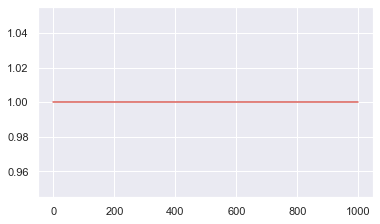

In [16]:
# We can also check that the internal normalization is true all the way along
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot([np.sum(xi_infer[:, :, i]) for i in range(xi_infer.shape[2])])
plt.show()


In [17]:
# Now, we can look into the parameter update equations

# The 0, 0 element of A_est gets updated by dividing the 0, 0 element of xi by
# the bayesian estimate of the system being in state 0 at time t

A_00 = np.sum(xi_infer[0, 0, :]) / np.sum(exp_res.gamma_k(0)[:-1])
A_01 = np.sum(xi_infer[0, 1, :]) / np.sum(exp_res.gamma_k(0)[:-1])
A_10 = np.sum(xi_infer[1, 0, :]) / np.sum(exp_res.gamma_k(1)[:-1])
A_11 = np.sum(xi_infer[1, 1, :]) / np.sum(exp_res.gamma_k(1)[:-1])

A_00, A_01, A_10, A_11

(0.7665155696228538,
 0.2252948866935382,
 0.24050015276198183,
 0.7679680099529229)

In [18]:
A_new = np.array([[A_00, A_01], [A_10, A_11]])
A_new, A_est

(array([[0.76651557, 0.22529489],
        [0.24050015, 0.76796801]]),
 array([[0.79, 0.21],
        [0.21, 0.79]]))

In [19]:
# we might have to re-normalize the columns here...
np.sum(A_new, axis=1)

array([0.99181046, 1.00846816])

In [20]:
A_new2 = np.zeros_like(A_new)

In [21]:
A_new2[:, 0] = A_new[:, 0] / np.sum(A_new[:, 0])
A_new2[:, 1] = A_new[:, 1] / np.sum(A_new[:, 1])

In [22]:
A_new2.sum(axis=0)

array([1., 1.])

In [23]:
# Now we can update the observation matrix as well

B_00 = np.sum(exp_res.gamma_k(0)[np.array(obs_ts) == 0]) / np.sum(exp_res.gamma_k(0))
B_01 = np.sum(exp_res.gamma_k(1)[np.array(obs_ts) == 0]) / np.sum(exp_res.gamma_k(1))
B_11 = np.sum(exp_res.gamma_k(1)[np.array(obs_ts) == 1]) / np.sum(exp_res.gamma_k(1))
B_10 = np.sum(exp_res.gamma_k(0)[np.array(obs_ts) == 1]) / np.sum(exp_res.gamma_k(0))

In [24]:
B_est

array([[0.87, 0.13],
       [0.13, 0.87]])

In [25]:
B_new = np.zeros_like(B_est)

B_new[0, 0] = B_00
B_new[0, 1] = B_01
B_new[1, 1] = B_11
B_new[1, 0] = B_10

In [26]:
B_new

array([[0.85928657, 0.1352155 ],
       [0.14071343, 0.8647845 ]])

In [27]:
B_est

array([[0.87, 0.13],
       [0.13, 0.87]])

In [28]:
# Might need to again enforce normalization here
B_new2 = np.zeros_like(B_est)
B_new2[:, 0] = B_new[:, 0] / np.sum(B_new[:, 0])
B_new2[:, 1] = B_new[:, 1] / np.sum(B_new[:, 1])

In [29]:
B_new2.sum(axis=0)

array([1., 1.])

In [30]:
# We can capture this behavbiour in funn by running a single iteration sof the build-in Baum-Welch algorithm
exp = bayes_infer.expectation(obs_ts, A_est, B_est)
maxim = bayes_infer.maximization(exp, obs_ts)
A_est, B_est = maxim.A, maxim.B

In [31]:
exp.__dict__.keys()

dict_keys(['gamma', 'alpha', 'beta', 'A', 'B', 'dim'])

In [32]:
maxim.__dict__.keys()

dict_keys(['A', 'B', 'A_prev', 'B_prev'])

In [33]:
maxim.A, maxim.A_prev

(array([[0.76117537, 0.22682302],
        [0.23882463, 0.77317698]]),
 array([[0.79, 0.21],
        [0.21, 0.79]]))

In [45]:
# now we can iterate this many times to see
a = 0.1
b = 0.2

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

hmm.initialize_dynamics(A, B)
hmm.run_dynamics(10000)
obs_ts = hmm.get_obs_ts()
state_ts = hmm.get_state_ts()

A_tracker = np.zeros((2, 2, 100))
B_tracker = np.zeros((2, 2, 100))

a_est = 0.21
b_est = 0.13

A_est = np.array([[1 - a_est, a_est],[a_est, 1 - a_est]])
B_est = np.array([[1 - b_est, b_est],[b_est, 1 - b_est]])

for iteration in range(100):
    exp = bayes_infer.expectation(obs_ts, A_est, B_est)
    maxim = bayes_infer.maximization(exp, obs_ts)
    A_est, B_est = maxim.A, maxim.B
    A_tracker[:, :, iteration] = maxim.A[:, :]
    B_tracker[:, :, iteration] = maxim.B[:, :]

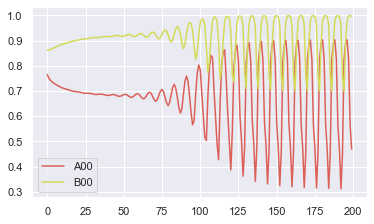

In [47]:
A_00_opt = A_tracker[0, 0, :]
B_00_opt = B_tracker[0, 0, :]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(A_00_opt, label='A00')
ax.plot(B_00_opt, label='B00')
ax.legend()